# Persoalan
Unduhlah salah satu data di situs SEKI https://www.bi.go.id/id/statistik/ekonomi-
keuangan/seki/default.aspx , Lakukan  prediktif analitik, time series forecasting untuk 
menganalisis ada tidaknya tren, siklus atau seasonal. Berikan penjelasan hasil perhitungan 
dan carilah perhitungan performanya.

## Packages

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Input Data

In [22]:
df = pd.read_excel('../dataset/TABEL7_1_revisi.xlsx', sheet_name='Sheet3')

In [23]:
# df = df.rename(columns={'PRODUK DOMESTIK BRUTO':'PDB'})
df['Quarter'] = pd.to_datetime(df['Quarter'], errors='coerce')
df = df.set_index('Quarter')

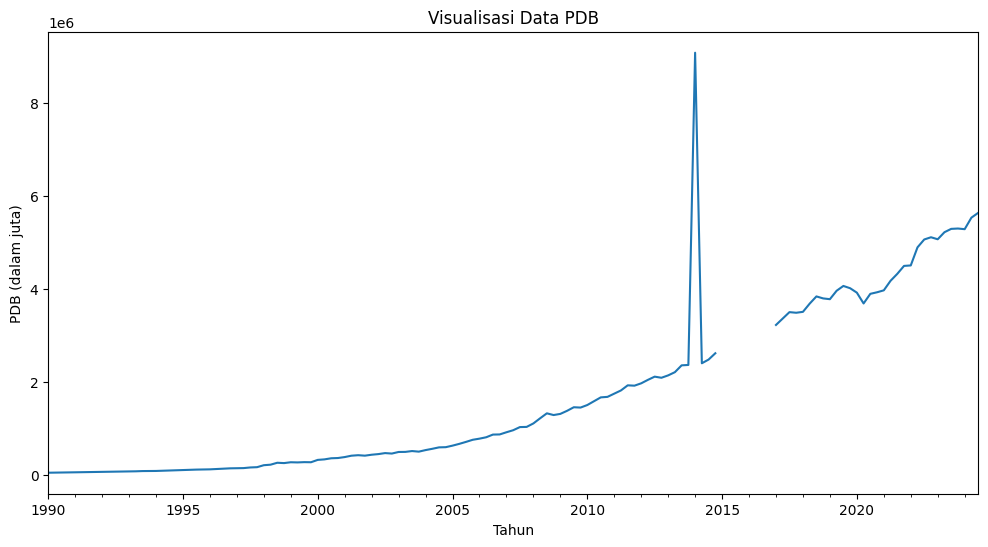

In [24]:
# Plot data
df['PRODUK DOMESTIK BRUTO'].plot(title="Visualisasi Data PDB", figsize=(12, 6))
plt.xlabel("Tahun")
plt.ylabel("PDB (dalam juta)")
plt.show()

## Cleaning Data

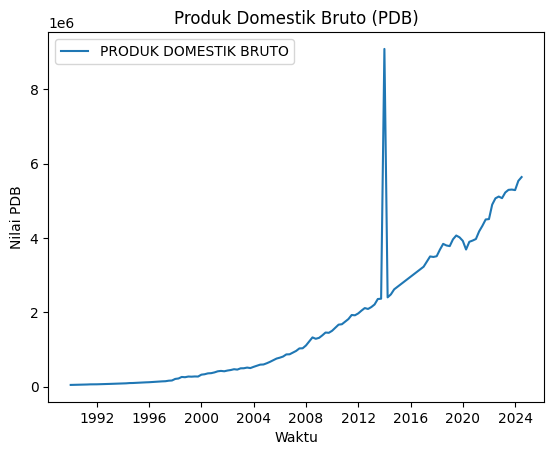

In [25]:
df['PRODUK DOMESTIK BRUTO'] = df['PRODUK DOMESTIK BRUTO'].interpolate(method='linear')
plt.plot(df.index, df['PRODUK DOMESTIK BRUTO'], label='PRODUK DOMESTIK BRUTO')
plt.title('Produk Domestik Bruto (PDB)')
plt.xlabel('Waktu')
plt.ylabel('Nilai PDB')
plt.legend()
plt.show()

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['PRODUK DOMESTIK BRUTO'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data tidak stasioner. Differencing diperlukan.")
else:
    print("Data sudah stasioner.")


ADF Statistic: 1.1591752135224198
p-value: 0.9956913214458238
Data tidak stasioner. Differencing diperlukan.


In [27]:
df['PDB_DIFF'] = df['PRODUK DOMESTIK BRUTO'].diff().dropna()

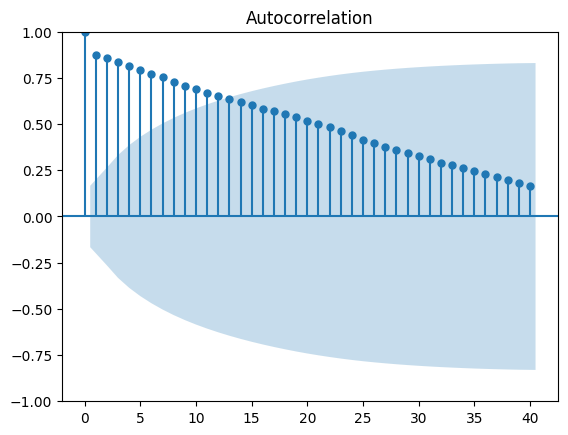

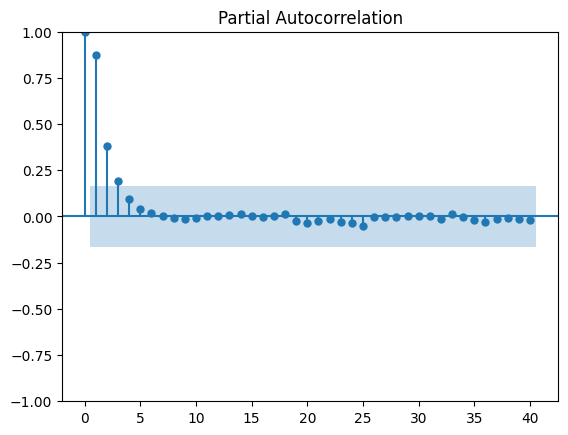

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['PRODUK DOMESTIK BRUTO'].dropna(), lags=40)
plot_pacf(df['PRODUK DOMESTIK BRUTO'].dropna(), lags=40)
plt.show()

In [31]:
print(df['PRODUK DOMESTIK BRUTO'].isnull().sum())  # Jumlah NaN
print(df['PRODUK DOMESTIK BRUTO'].describe())

0
count    1.390000e+02
mean     1.724496e+06
std      1.781263e+06
min      4.995840e+04
25%      2.606848e+05
50%      9.638625e+05
75%      2.991610e+06
max      9.083972e+06
Name: PRODUK DOMESTIK BRUTO, dtype: float64


## Prediction

/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_533057/3709281829.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')


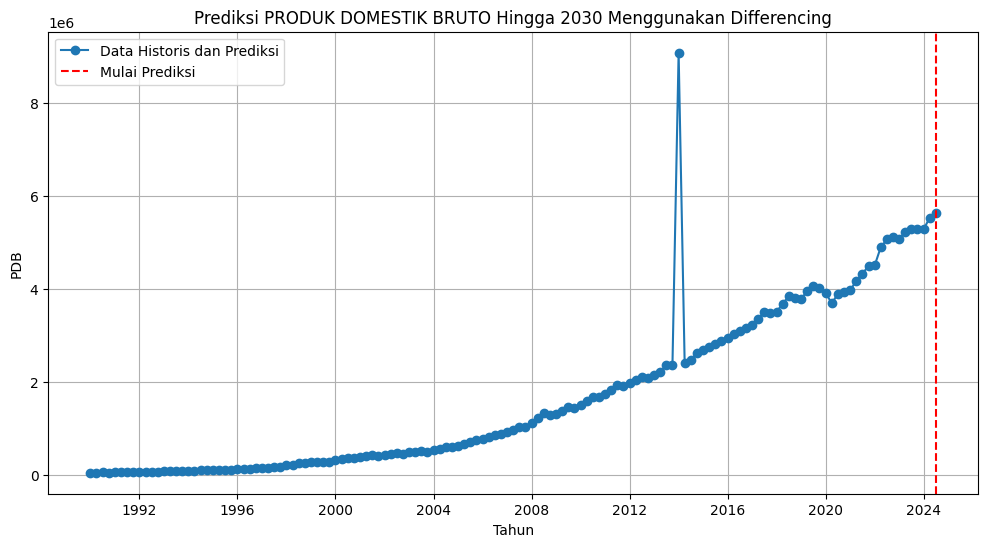

            PRODUK DOMESTIK BRUTO
2024-12-31                    NaN
2025-03-31                    NaN
2025-06-30                    NaN
2025-09-30                    NaN
2025-12-31                    NaN
2026-03-31                    NaN
2026-06-30                    NaN
2026-09-30                    NaN
2026-12-31                    NaN
2027-03-31                    NaN
2027-06-30                    NaN
2027-09-30                    NaN
2027-12-31                    NaN
2028-03-31                    NaN
2028-06-30                    NaN
2028-09-30                    NaN
2028-12-31                    NaN
2029-03-31                    NaN
2029-06-30                    NaN
2029-09-30                    NaN
2029-12-31                    NaN
2030-03-31                    NaN
2030-06-30                    NaN
2030-09-30                    NaN


In [34]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan data bersih dan interpolasi nilai kosong
df['PRODUK DOMESTIK BRUTO'] = df['PRODUK DOMESTIK BRUTO'].interpolate(method='linear')

# Lakukan differencing untuk membuat data stasioner
df['PDB_DIFF'] = df['PRODUK DOMESTIK BRUTO'].diff().dropna()

# Buat model ARIMA menggunakan data differenced
model = ARIMA(df['PDB_DIFF'].dropna(), order=(1, 0, 1))  # d=0 karena sudah differenced
model_fit = model.fit()

# Prediksi 24 kuartal (hingga 2030)
forecast_steps = (2030 - 2024) * 4
forecast_diff = model_fit.forecast(steps=forecast_steps)

# Kembalikan hasil prediksi ke skala asli
forecast_cumsum = forecast_diff.cumsum()  # Cumulative sum untuk membalik differencing
last_actual_value = df['PRODUK DOMESTIK BRUTO'].iloc[-1]
forecast_original_scale = last_actual_value + forecast_cumsum

# Membuat DataFrame prediksi
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')
forecast_df = pd.DataFrame({'PRODUK DOMESTIK BRUTO': forecast_original_scale}, index=future_dates)

# Gabungkan data historis dan prediksi
result = pd.concat([df[['PRODUK DOMESTIK BRUTO']], forecast_df])

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(result.index, result['PRODUK DOMESTIK BRUTO'], label='Data Historis dan Prediksi', marker='o')
plt.axvline(x=df.index[-1], color='red', linestyle='--', label='Mulai Prediksi')
plt.title('Prediksi PRODUK DOMESTIK BRUTO Hingga 2030 Menggunakan Differencing')
plt.xlabel('Tahun')
plt.ylabel('PDB')
plt.legend()
plt.grid()
plt.show()

# Menampilkan hasil prediksi
print(forecast_df)


In [35]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               PDB_DIFF   No. Observations:                  138
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2036.641
Date:                Fri, 13 Dec 2024   AIC                           4081.282
Time:                        15:56:06   BIC                           4092.991
Sample:                    04-01-1990   HQIC                          4086.040
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.05e+04   1.29e+04      3.149      0.002    1.53e+04    6.57e+04
ar.L1         -0.0398      0.079     -0.507      0.612      -0.194       0.114
ma.L1         -0.8029      0.066    -12.108      0.0

In [36]:
result

,PRODUK DOMESTIK BRUTO
1990-01-01,49958.4
1990-04-01,51681.6
1990-07-01,54864.6
1990-10-01,54361.6
1991-01-01,58937.2
...,...
2029-09-30,NaN
2029-12-31,NaN
2030-03-31,NaN
2030-06-30,NaN
